<a href="https://colab.research.google.com/github/ColmTalbot/windowing-in-parameter-estimation/blob/main/notebooks/GW150914_windowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating the impact of the window factor in Bilby

The first few cells go through some preamble to install needed packages including latex for plotting, download PSD data, and import needed packages.

**NOTE**: this notebook must use `bilby<2.6` as the $\beta$ was removed in that release.

In [1]:
!pip install "bilby<2.6" lalsuite gwpy gwosc nestle

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 277.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.9/983.9 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.4 MB/s eta 0:00:00
  Created w

In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-science

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-gfs-baskerville
  fonts-gfs-porson fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern pfb2t1c2pfb poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-lang-greek
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | f

In [3]:
!wget https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat

--2025-08-01 12:54:13--  https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312864 (306K)
Saving to: ‘GWTC1_GW150914_PSDs.dat’

GWTC1_GW150914_PSDs 100%[===================>] 305.53K   479KB/s    in 0.6s    

2025-08-01 12:54:15 (479 KB/s) - ‘GWTC1_GW150914_PSDs.dat’ saved [312864/312864]



In [4]:
from copy import deepcopy

import lal

_ = lal.swig_redirect_standard_output_error(False)

import bilby
import numpy as np
from bilby.core.prior import Uniform, Sine
from bilby.gw.likelihood.base import GravitationalWaveTransient
from bilby.gw.prior import UniformSourceFrame, UniformInComponentsMassRatio, UniformInComponentsChirpMass
from gwpy.timeseries import TimeSeries
from gwosc import datasets
from scipy.special import logsumexp

import matplotlib as mpl

mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath} \usepackage{amssymb}"
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "cm"

/tmp/ipython-input-3943914801.py:3: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## Basic settings

First we set various settings for the analyses.
We choose to use a 4s segment duration to maximize the impact on the results.
We limit ourselves to a maximum frequency of 512 Hz which is probably sufficient for GW150914.

We use three Tukey roll off times:
- $\delta t=0s$ ($\alpha = 0$): a rectangular window
- $\delta t = 0.2s$ ($\alpha = 0.1$): this is the same $\alpha$ used during the initial analysis of GW150914
- $\delta t = 1s$ ($\alpha = 0.5$): this is the most extreme value used routinely in LVK analyses

In [5]:
event = "GW150914"

trigger_time = datasets.event_gps(event)
detectors = datasets.event_detectors(event)
maximum_frequency = 512
minimum_frequency = 20
duration = 4
post_trigger_duration = 2
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

data = dict()
for det in detectors:
    data[det] = TimeSeries.fetch_open_data(det, start_time, end_time).highpass(12)

psds = dict()
freqs, psds["H1"], psds["L1"] = np.genfromtxt("GWTC1_GW150914_PSDs.dat").T

roll_offs = [0.0, 0.2, 1.0]

## Set up waveform and prior

We're using the IMRPhenomD waveform model for speed and including higher-order waveform effects isn't relevant for this analysis.
Additionally, we set the spins of both items in the binary to zero.

In [6]:
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomD",
        "reference_frequency": 50,
    },
)

priors = bilby.gw.prior.BBHPriorDict(dict(
    chirp_mass=UniformInComponentsChirpMass(name='chirp_mass', minimum=25, maximum=35, unit='$M_{\odot}$'),
    mass_ratio=UniformInComponentsMassRatio(name='mass_ratio', minimum=0.125, maximum=1),
    chi_1=0,
    chi_2=0,
    luminosity_distance=bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=50, maximum=2000, latex_label='$d_L$'),
    zenith=Sine(latex_label="$\\kappa$"),
    azimuth=Uniform(0, 2 * np.pi, name="azimuth", latex_label="$\\epsilon$"),
    theta_jn=Sine(name='theta_jn'),
    psi=Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
    phase=Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    H1_time=Uniform(trigger_time - 0.1, trigger_time + 0.1, name="H1_time")
))

12:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


## Perform our analyses with the old likelihood definition.

There's nothing particularly profound here.

In [7]:
results = list()

for roll_off in roll_offs:
    outdir = "old_version"
    label = f"GW150914_window_{roll_off:.1f}"

    ifo_list = bilby.gw.detector.InterferometerList([])
    for det in detectors:
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        ifo.strain_data.roll_off = roll_off
        ifo.strain_data.set_from_gwpy_timeseries(data[det])

        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=freqs, psd_array=psds[ifo.name]
        )
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        ifo_list.append(ifo)

    bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
    ifo_list.plot_data(outdir=outdir, label=label)

    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        ifo_list,
        waveform_generator,
        priors=priors,
        phase_marginalization=True,
        distance_marginalization=True,
        reference_frame="H1L1",
        time_reference="H1",
    )

    result = bilby.run_sampler(
        likelihood,
        priors,
        sampler="nestle",
        outdir=outdir,
        label=label,
        nlive=500,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        clean=True,
        resume=False,
    )
    result.plot_corner()
    results.append(result)

12:54 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
12:54 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

13:01 bilby INFO    : Running for label 'GW150914_window_0.0', output will be saved to 'old_version'
13:01 bilby INFO    : Using lal version 7.7.0
13:01 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:01 bilby INFO    : Using lalsimulation version 6.2.0
13:01 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:01 bilby INFO    : Analysis priors:
13:01 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
13:01 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, bo

it=  9182 logz=179.046134


13:05 bilby INFO    : Sampling time: 0:03:30.982711
13:05 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9683 [00:00<?, ?it/s]

13:05 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9683 [00:00<?, ?it/s]

13:07 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9683 [00:00<?, ?it/s]

13:07 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9683 [00:00<?, ?it/s]

13:08 bilby INFO    : Summary of results:
nsamples: 9683
ln_noise_evidence: -52026.676
ln_evidence: -51847.396 +/-  0.172
ln_bayes_factor: 179.280 +/-  0.172

13:09 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:09 bilby INFO    : Running for label 'GW150914_window_0.2', output will be saved to 'old_version'
13:09 bilby INFO    : Using lal version 7.7.0
13:09 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:09 bilby INFO    : Using lalsimulation version 6.2.0
13:09 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:09 bilby INFO    : Analysis priors:
13:09 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChir

it=  9251 logz=191.834982


13:12 bilby INFO    : Sampling time: 0:02:49.801790
13:12 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9752 [00:00<?, ?it/s]

13:12 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9752 [00:00<?, ?it/s]

13:14 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9752 [00:00<?, ?it/s]

13:14 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9752 [00:00<?, ?it/s]

13:15 bilby INFO    : Summary of results:
nsamples: 9752
ln_noise_evidence: -4839.602
ln_evidence: -4647.553 +/-  0.173
ln_bayes_factor: 192.048 +/-  0.173

13:15 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:15 bilby INFO    : Running for label 'GW150914_window_1.0', output will be saved to 'old_version'
13:15 bilby INFO    : Using lal version 7.7.0
13:15 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:15 bilby INFO    : Using lalsimulation version 6.2.0
13:15 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:15 bilby INFO    : Analysis priors:
13:15 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpM

it=  9686 logz=269.714363


13:18 bilby INFO    : Sampling time: 0:02:37.850050
13:18 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/10187 [00:00<?, ?it/s]

13:18 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/10187 [00:00<?, ?it/s]

13:21 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/10187 [00:00<?, ?it/s]

13:21 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/10187 [00:00<?, ?it/s]

13:22 bilby INFO    : Summary of results:
nsamples: 10187
ln_noise_evidence: -3711.409
ln_evidence: -3441.482 +/-  0.178
ln_bayes_factor: 269.927 +/-  0.178



## Perform our analyses with the new likelihood definition.

To achieve this, we manually set the `Interferometer.strain_data.window_factor`.
Note that this has to be done after a throwaway call to `Interferometer.frequency_domain_strain`, which sets the value upon the FFT call.

In [8]:
results = list()

for roll_off in roll_offs:
    outdir = "new_version"
    label = f"GW150914_window_{roll_off:.1f}"

    ifo_list = bilby.gw.detector.InterferometerList([])
    for det in detectors:
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        ifo.strain_data.roll_off = roll_off
        ifo.strain_data.set_from_gwpy_timeseries(data[det])

        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=freqs, psd_array=psds[ifo.name]
        )
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        _ = ifo.frequency_domain_strain
        ifo.strain_data.window_factor = 1
        ifo_list.append(ifo)

    bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
    ifo_list.plot_data(outdir=outdir, label=label)

    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        ifo_list,
        waveform_generator,
        priors=priors,
        phase_marginalization=True,
        distance_marginalization=True,
        reference_frame="H1L1",
        time_reference="H1",
    )

    result = bilby.run_sampler(
        likelihood,
        priors,
        sampler="nestle",
        outdir=outdir,
        label=label,
        nlive=500,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        clean=True,
        resume=False,
    )
    result.plot_corner()
    results.append(result)

13:22 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:22 bilby INFO    : Running for label 'GW150914_window_0.0', output will be saved to 'new_version'
13:22 bilby INFO    : Using lal version 7.7.0
13:22 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:22 bilby INFO    : Using lalsimulation version 6.2.0
13:22 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:22 bilby INFO    : Analysis priors:
13:22 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
13:22 bilby INFO    : mass_ratio=bilby.gw.pr

it=  9244 logz=179.133202


13:26 bilby INFO    : Sampling time: 0:04:19.637143
13:26 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9745 [00:00<?, ?it/s]

13:27 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9745 [00:00<?, ?it/s]

13:31 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9745 [00:00<?, ?it/s]

13:31 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9745 [00:00<?, ?it/s]

13:32 bilby INFO    : Summary of results:
nsamples: 9745
ln_noise_evidence: -52026.676
ln_evidence: -51847.332 +/-  0.172
ln_bayes_factor: 179.344 +/-  0.172

13:32 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:32 bilby INFO    : Running for label 'GW150914_window_0.2', output will be saved to 'new_version'
13:32 bilby INFO    : Using lal version 7.7.0
13:32 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:32 bilby INFO    : Using lalsimulation version 6.2.0
13:32 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:32 bilby INFO    : Analysis priors:
13:32 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChir

it=  9242 logz=178.349519


13:35 bilby INFO    : Sampling time: 0:02:29.482611
13:35 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9743 [00:00<?, ?it/s]

13:35 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9743 [00:00<?, ?it/s]

13:37 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9743 [00:00<?, ?it/s]

13:37 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9743 [00:00<?, ?it/s]

13:38 bilby INFO    : Summary of results:
nsamples: 9743
ln_noise_evidence: -4536.850
ln_evidence: -4358.297 +/-  0.171
ln_bayes_factor: 178.553 +/-  0.171

13:39 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:39 bilby INFO    : Running for label 'GW150914_window_1.0', output will be saved to 'new_version'
13:39 bilby INFO    : Using lal version 7.7.0
13:39 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:39 bilby INFO    : Using lalsimulation version 6.2.0
13:39 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:39 bilby INFO    : Analysis priors:
13:39 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpM

it=  9265 logz=178.001708


13:41 bilby INFO    : Sampling time: 0:02:54.281701
13:41 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9766 [00:00<?, ?it/s]

13:42 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9766 [00:00<?, ?it/s]

13:44 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9766 [00:00<?, ?it/s]

13:44 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9766 [00:00<?, ?it/s]

13:45 bilby INFO    : Summary of results:
nsamples: 9766
ln_noise_evidence: -2551.438
ln_evidence: -2373.206 +/-  0.173
ln_bayes_factor: 178.232 +/-  0.173



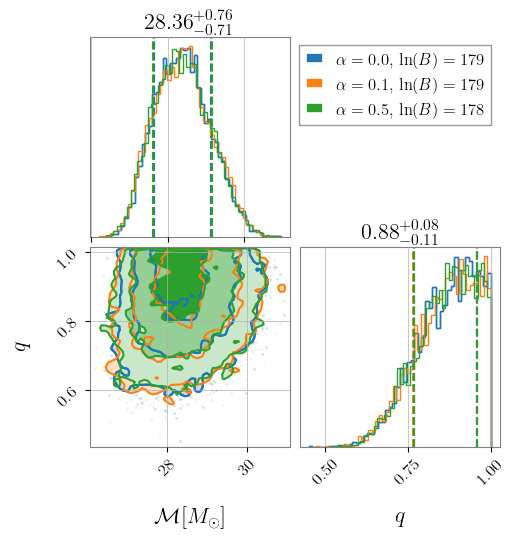

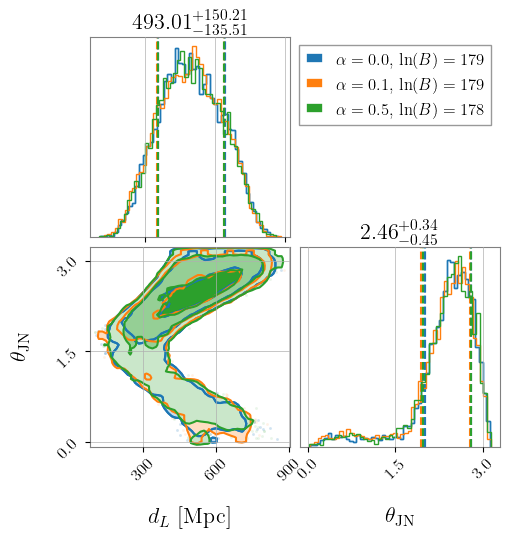

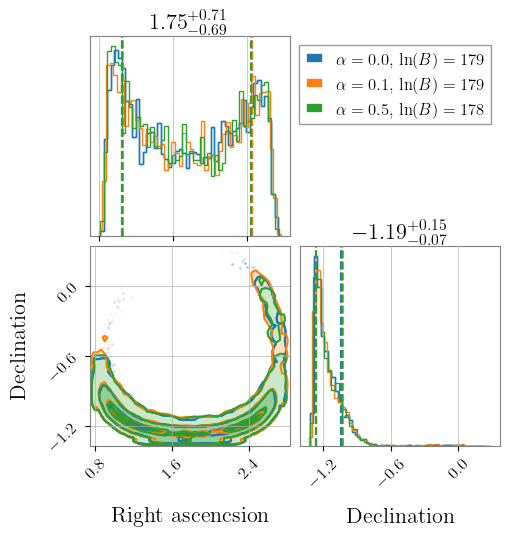

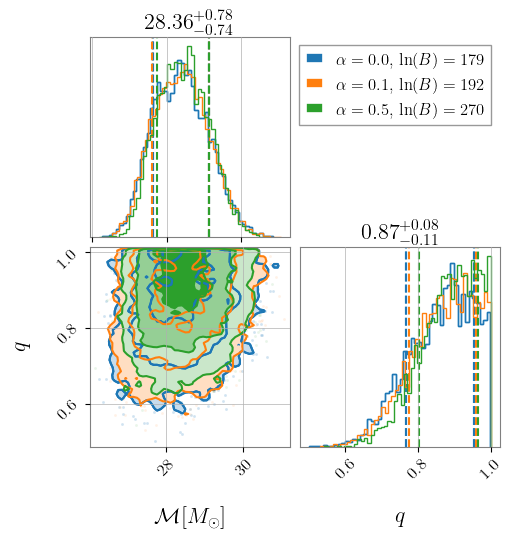

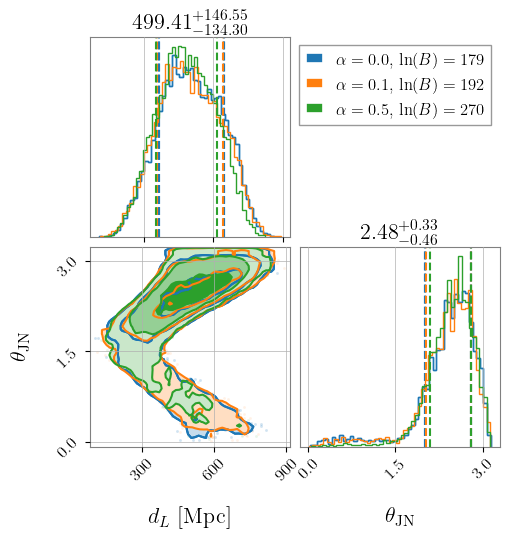

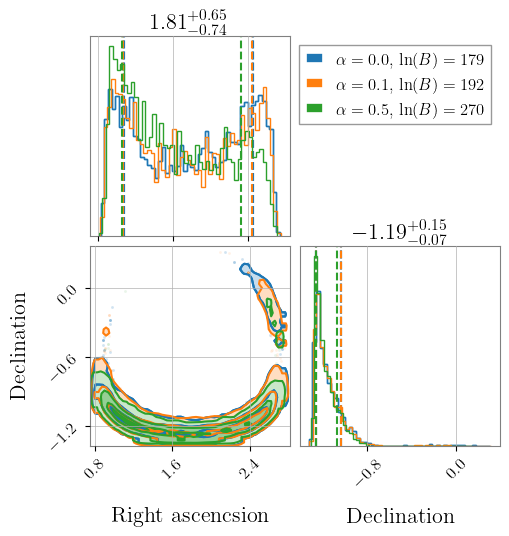

In [9]:
for kind in ["new", "old"]:

    results = [
        bilby.core.result.read_in_result(
            f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
            )
        for roll_off in roll_offs
    ]

    labels = [
        f"$\\alpha = {2 * roll_off / duration:.1f}$," for roll_off in roll_offs
    ]

    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["chirp_mass_source", "mass_ratio"],
        corner_labels=["$\\mathcal{M} [M_{\\odot}]$", "$q$"],
        labels=labels,
        filename=f"{kind}_version/comparison_mass_{kind}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["luminosity_distance", "theta_jn"],
        corner_labels=["$d_{L}$ [Mpc]", "$\\theta_{\\rm JN}$"],
        labels=labels,
        filename=f"{kind}_version/comparison_distance_{kind}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["ra", "dec"],
        corner_labels=["Right ascencsion", "Declination"],
        labels=labels,
        filename=f"{kind}_version/comparison_sky_{kind}.pdf",
        evidences=True,
    )


In [10]:
def crop_fd_data(data, sampling_frequency, duration, crop):
    """
    Crop the frequency domain data to the specified duration.

    Parameters
    ==========
    data: np.ndarray
        The frequency domain data.
    sampling_frequency: float
        The sampling frequency of the data.
    duration: float
        The duration of the data.
    crop: float
        The duration of data to remove from the start and end of the data.

    Returns
    =======
    np.ndarray
        The cropped frequency domain data.
    """
    idxs = slice(
        int(crop * sampling_frequency),
        int((duration - crop) * sampling_frequency)
    )
    return np.fft.rfft(np.fft.irfft(data)[idxs])


class CroppedGravitationalWaveTransient(GravitationalWaveTransient):
    """
    A likelihood that correctly handles the corruption of the data close to
    the edges of the data segment, by cropping the whitened time-domain
    strain and template.

    Parameters
    ==========
    crop: float
        The duration of data to crop from the start and end of the data segment.
    """

    def __init__(
        self,
        interferometers,
        waveform_generator,
        time_marginalization=False,
        distance_marginalization=False,
        phase_marginalization=False,
        calibration_marginalization=False,
        priors=None,
        distance_marginalization_lookup_table=None,
        calibration_lookup_table=None,
        number_of_response_curves=1000,
        starting_index=0,
        jitter_time=True,
        reference_frame="sky",
        time_reference="geocenter",
        crop=1,
    ):
        super().__init__(
            interferometers=deepcopy(interferometers),
            waveform_generator=deepcopy(waveform_generator),
            time_marginalization=time_marginalization,
            distance_marginalization=distance_marginalization,
            phase_marginalization=phase_marginalization,
            calibration_marginalization=calibration_marginalization,
            priors=priors,
            distance_marginalization_lookup_table=distance_marginalization_lookup_table,
            calibration_lookup_table=calibration_lookup_table,
            number_of_response_curves=number_of_response_curves,
            starting_index=starting_index,
            jitter_time=jitter_time,
            reference_frame=reference_frame,
            time_reference=time_reference,
        )
        self.duration = interferometers.duration
        self.sampling_frequency = interferometers.sampling_frequency
        self.whitened_data = {
            ifo.name: crop_fd_data(
                ifo.frequency_domain_strain / ifo.amplitude_spectral_density_array,
                ifo.sampling_frequency,
                ifo.duration,
                crop=crop,
            )
            for ifo in self.interferometers
        }
        self.crop = crop

    @property
    def duration_factor(self):
        return 4 / (self.duration - 2 * self.crop)

    def _calculate_noise_log_likelihood(self):
        return sum([
            -(abs(data**2)).sum() / 2 for data in self.whitened_data.values()
        ]) * self.duration_factor

    def project_and_whiten(self, waveform_polarizations, interferometer, parameters):
        signal = interferometer.get_detector_response(
            waveform_polarizations,
            parameters=parameters,
            frequencies=self.waveform_generator.frequency_array,
        )
        whitened = crop_fd_data(
            signal / interferometer.amplitude_spectral_density_array,
            self.sampling_frequency,
            self.duration,
            crop=self.crop
        )
        return whitened

    def calculate_snrs(self, waveform_polarizations, interferometer, return_array=False):
        parameters = self.parameters.copy()
        strain = self.project_and_whiten(waveform_polarizations, interferometer, parameters)
        data = self.whitened_data[interferometer.name]
        d_inner_h = (strain * data.conjugate()).sum() * self.duration_factor
        h_inner_h = (abs(strain)**2).sum() * self.duration_factor
        return self._CalculatedSNRs(
            d_inner_h=d_inner_h,
            optimal_snr_squared=h_inner_h,
            complex_matched_filter_snr = d_inner_h / h_inner_h**0.5,
        )


We need more data for the cropped likelihood, we are going to crop $2s$ of data on each side of the segment since the longest roll off we use is $1s$.

In [11]:
event = "GW150914"

trigger_time = datasets.event_gps(event)
detectors = datasets.event_detectors(event)
maximum_frequency = 512
minimum_frequency = 20
duration = 4
post_trigger_duration = 2
crop = 2
end_time = trigger_time + post_trigger_duration + crop
start_time = end_time - duration - 2 * crop

data = dict()
for det in detectors:
    data[det] = TimeSeries.fetch_open_data(det, start_time, end_time).highpass(12)

psds = dict()
freqs, psds["H1"], psds["L1"] = np.genfromtxt("GWTC1_GW150914_PSDs.dat").T

roll_offs = [0.0, 0.2, 1.0]

In [12]:
results = list()

for roll_off in roll_offs:
    outdir = "cropped_version"
    label = f"GW150914_window_{roll_off:.1f}"

    ifo_list = bilby.gw.detector.InterferometerList([])
    for det in detectors:
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        ifo.strain_data.roll_off = roll_off
        ifo.strain_data.set_from_gwpy_timeseries(data[det])

        ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=freqs, psd_array=psds[ifo.name]
        )
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        _ = ifo.frequency_domain_strain
        ifo.strain_data.window_factor = 1
        ifo_list.append(ifo)

    bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
    ifo_list.plot_data(outdir=outdir, label=label)

    likelihood = CroppedGravitationalWaveTransient(
        ifo_list,
        waveform_generator,
        priors=priors,
        phase_marginalization=True,
        distance_marginalization=True,
        reference_frame="H1L1",
        time_reference="H1",
        crop=crop,
    )

    result = bilby.run_sampler(
        likelihood,
        priors,
        sampler="nestle",
        outdir=outdir,
        label=label,
        nlive=500,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        clean=True,
        resume=False,
    )
    result.plot_corner()
    results.append(result)

13:46 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:46 bilby INFO    : Running for label 'GW150914_window_0.0', output will be saved to 'cropped_version'
13:46 bilby INFO    : Using lal version 7.7.0
13:46 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:46 bilby INFO    : Using lalsimulation version 6.2.0
13:46 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:46 bilby INFO    : Analysis priors:
13:46 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
13:46 bilby INFO    : mass_ratio=bilby.g

it=  9337 logz=179.635553


13:55 bilby INFO    : Sampling time: 0:09:17.208727
13:55 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9838 [00:00<?, ?it/s]

13:56 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9838 [00:00<?, ?it/s]

14:00 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9838 [00:00<?, ?it/s]

14:00 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9838 [00:00<?, ?it/s]

14:02 bilby INFO    : Summary of results:
nsamples: 9838
ln_noise_evidence: -3444.234
ln_evidence: -3264.375 +/-  0.174
ln_bayes_factor: 179.859 +/-  0.174

14:02 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
14:02 bilby INFO    : Running for label 'GW150914_window_0.2', output will be saved to 'cropped_version'
14:02 bilby INFO    : Using lal version 7.7.0
14:02 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:02 bilby INFO    : Using lalsimulation version 6.2.0
14:02 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:02 bilby INFO    : Analysis priors:
14:02 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsCh

it=  9081 logz=178.283198


14:08 bilby INFO    : Sampling time: 0:05:57.542626
14:08 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9582 [00:00<?, ?it/s]

14:09 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9582 [00:00<?, ?it/s]

14:13 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9582 [00:00<?, ?it/s]

14:13 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9582 [00:00<?, ?it/s]

14:14 bilby INFO    : Summary of results:
nsamples: 9582
ln_noise_evidence: -3426.793
ln_evidence: -3248.284 +/-  0.171
ln_bayes_factor: 178.510 +/-  0.171

14:15 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
14:15 bilby INFO    : Running for label 'GW150914_window_1.0', output will be saved to 'cropped_version'
14:15 bilby INFO    : Using lal version 7.7.0
14:15 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:15 bilby INFO    : Using lalsimulation version 6.2.0
14:15 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.26.1;Id: c90e1175f5e238741185744a4e516e58d42a9aec;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:15 bilby INFO    : Analysis priors:
14:15 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsCh

it=  9218 logz=178.389395


14:20 bilby INFO    : Sampling time: 0:05:27.870734
14:20 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/9719 [00:00<?, ?it/s]

14:21 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/9719 [00:00<?, ?it/s]

14:25 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/9719 [00:00<?, ?it/s]

14:25 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/9719 [00:00<?, ?it/s]

14:27 bilby INFO    : Summary of results:
nsamples: 9719
ln_noise_evidence: -3431.009
ln_evidence: -3252.410 +/-  0.172
ln_bayes_factor: 178.599 +/-  0.172



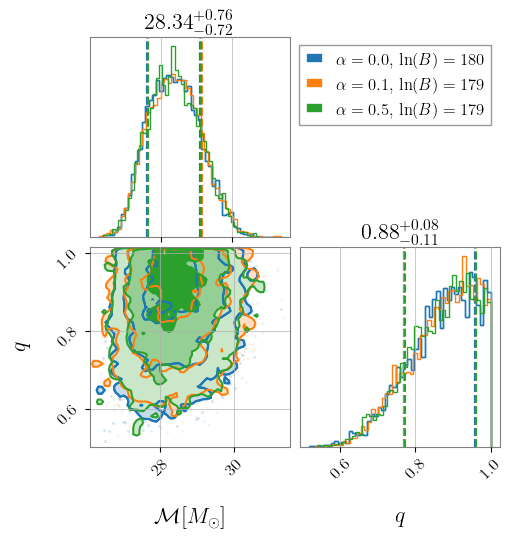

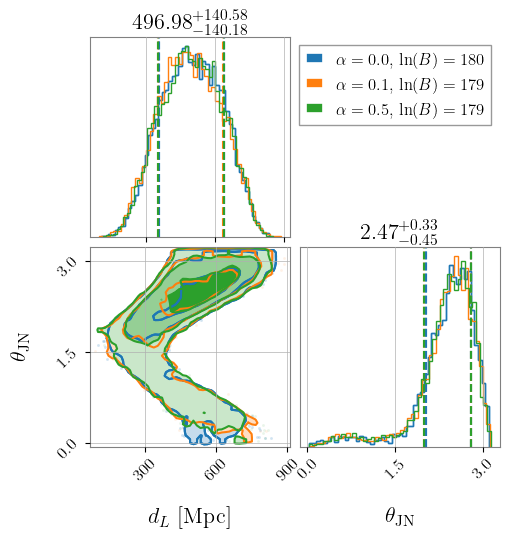

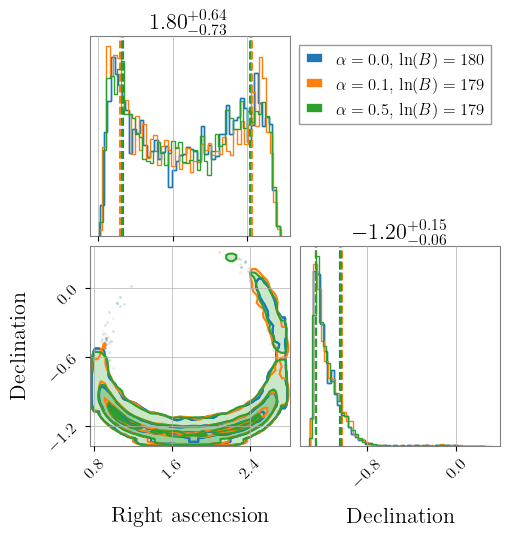

In [13]:
for kind in ["cropped"]:

    results = [
        bilby.core.result.read_in_result(
            f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
            )
        for roll_off in roll_offs
    ]

    labels = [
        f"$\\alpha = {2 * roll_off / duration:.1f}$," for roll_off in roll_offs
    ]

    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["chirp_mass_source", "mass_ratio"],
        corner_labels=["$\\mathcal{M} [M_{\\odot}]$", "$q$"],
        labels=labels,
        filename=f"{kind}_version/comparison_mass_{kind}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["luminosity_distance", "theta_jn"],
        corner_labels=["$d_{L}$ [Mpc]", "$\\theta_{\\rm JN}$"],
        labels=labels,
        filename=f"{kind}_version/comparison_distance_{kind}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["ra", "dec"],
        corner_labels=["Right ascencsion", "Declination"],
        labels=labels,
        filename=f"{kind}_version/comparison_sky_{kind}.pdf",
        evidences=True,
    )


## Importance sampling incorrect results

One approach to correct the results applied when including the $\beta$ factor is to importance sample the posterior using the ratio of the likelihood without and with $\beta$.

The importance weights are defined as
$$
w_i = \frac{L(d | \theta)}{L_{\beta}(d | \theta)} = L(d | \theta)^{-\frac{5 \alpha}{8}}.
$$
The Bayes factor comparing the reweighted evidence to the original evidence is just the mean weight $\langle w_i \rangle$ and the additional uncertainty in the log is
$$\frac{1}{N_{\rm samples}} \frac{{\rm Var}[w_i]}{\langle W_i\rangle}.$$

For large values of $\alpha$ the rejection sampling efficiency is very small, but the new evidence estimate is accurate.

In [53]:
kind = "old"

for roll_off in roll_offs:

    result = bilby.core.result.read_in_result(
        f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
    )

    d_inner_h = sum([
        result.posterior[f"{det}_matched_filter_snr"].values.real
        * result.posterior[f"{det}_optimal_snr"].values.real
        for det in detectors
    ])
    optimal_snr = sum([result.posterior[f"{det}_optimal_snr"].values.real**2 for det in detectors])**0.5
    simple_ln_likelihood = - optimal_snr**2 / 2 + d_inner_h

    ln_weights = simple_ln_likelihood * (-5 * 2 * roll_off / 8 / duration)

    ln_bayes_factor = logsumexp(ln_weights) - np.log(len(ln_weights))
    new_ln_evidence = result.log_bayes_factor + ln_bayes_factor

    ln_sum_w_squared = logsumexp(2 * ln_weights) - np.log(len(ln_weights))
    new_variance_ln = (np.exp(ln_sum_w_squared - 2 * ln_bayes_factor) - 1) / len(ln_weights)
    new_ln_evidence_error = (result.log_evidence_err**2 + new_variance_ln)**0.5

    result.log_bayes_factor = new_ln_evidence
    result.log_noise_evidence *= 1 - 5 * 2 * roll_off / 8 / duration
    result.log_evidence = result.log_bayes_factor + result.log_noise_evidence
    keep = np.exp(ln_weights) > np.random.uniform(0, max(np.exp(ln_weights)), len(ln_weights))
    result.posterior = result.posterior[keep]
    result.save_to_file(outdir="reweighted_version")

    print(
        f"Reweighted ln evidence: {new_ln_evidence:.2f} +/- "
        f"{new_ln_evidence_error:.2f}, rejection sampling efficiency: "
        f"{len(result.posterior) / len(ln_weights):.3f}"
    )

Reweighted ln evidence: 179.28 +/- 0.17, rejection sampling efficiency: 1.000
Reweighted ln evidence: 178.73 +/- 0.17, rejection sampling efficiency: 0.362
Reweighted ln evidence: 179.34 +/- 0.18, rejection sampling efficiency: 0.007


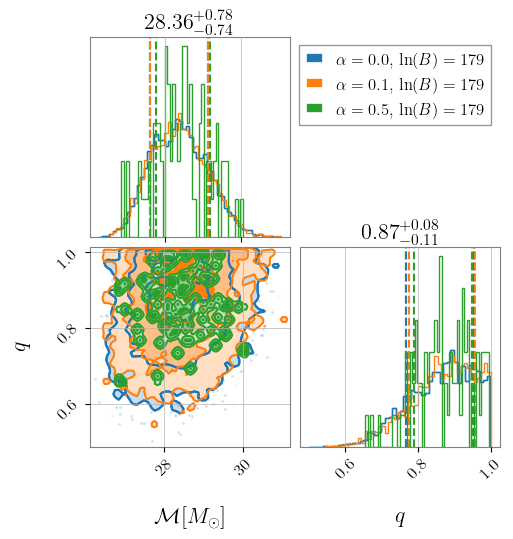

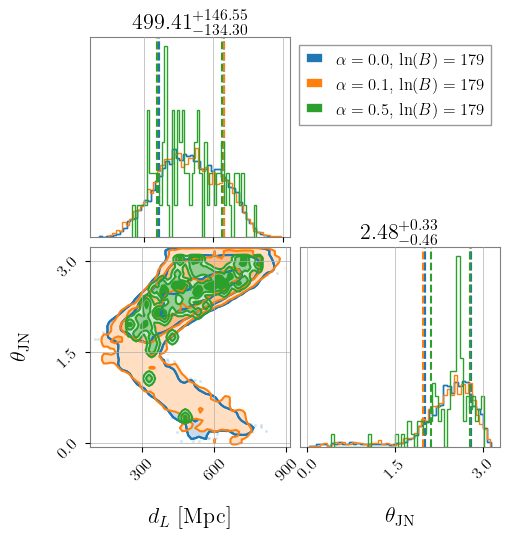

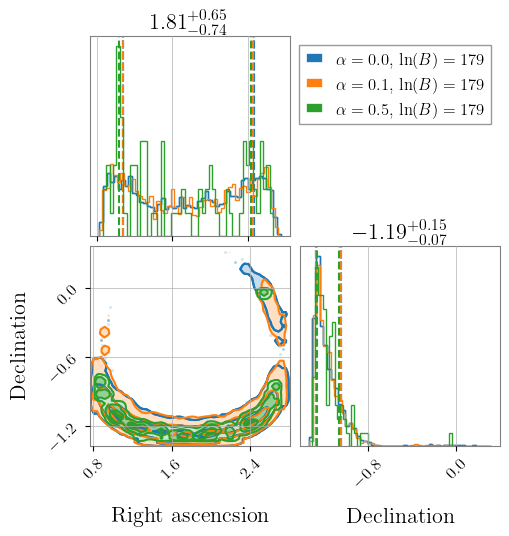

In [52]:
kind = "reweighted"

results = [
    bilby.core.result.read_in_result(
        f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
        )
    for roll_off in roll_offs
]

labels = [
    f"$\\alpha = {2 * roll_off / duration:.1f}$," for roll_off in roll_offs
]

_ = bilby.core.result.plot_multiple(
    results,
    parameters=["chirp_mass_source", "mass_ratio"],
    corner_labels=["$\\mathcal{M} [M_{\\odot}]$", "$q$"],
    labels=labels,
    filename=f"{kind}_version/comparison_mass_{kind}.pdf",
    evidences=True,
)
_ = bilby.core.result.plot_multiple(
    results,
    parameters=["luminosity_distance", "theta_jn"],
    corner_labels=["$d_{L}$ [Mpc]", "$\\theta_{\\rm JN}$"],
    labels=labels,
    filename=f"{kind}_version/comparison_distance_{kind}.pdf",
    evidences=True,
)
_ = bilby.core.result.plot_multiple(
    results,
    parameters=["ra", "dec"],
    corner_labels=["Right ascencsion", "Declination"],
    labels=labels,
    filename=f"{kind}_version/comparison_sky_{kind}.pdf",
    evidences=True,
)


In [51]:
evidences = dict()

for kind in ["new", "old", "cropped", "reweighted"]:
    temp = dict()
    for roll_off in roll_offs:
        result = bilby.core.result.read_in_result(
            f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
        )
        temp[roll_off] = result.log_evidence
    evidences[kind] = temp


print(f"""
\\begin{{tabular}}{{|c|c|c|c|}}
\\hline
& $r = 0s$ & $r = 0.2s$ & $r = 1s$ \\\\
\\hline
with $\\beta$ & ${evidences['old'][0.0]:.0f}$ & ${evidences['old'][0.2]:.0f}$ & ${evidences['old'][1.0]:.0f}$ \\\\
without $\\beta$ reweighted & ${evidences['reweighted'][0.0]:.0f}$ & ${evidences['reweighted'][0.2]:.0f}$ & ${evidences['reweighted'][1.0]:.0f}$ \\\\
without $\\beta$ & ${evidences['new'][0.0]:.0f}$ & ${evidences['new'][0.2]:.0f}$ & ${evidences['new'][1.0]:.0f}$ \\\\
cropped & ${evidences['cropped'][0.0]:.0f}$ & ${evidences['cropped'][0.2]:.0f}$ & ${evidences['cropped'][1.0]:.0f}$ \\\\
\\hline
\\end{{tabular}}
""")


\begin{tabular}{|c|c|c|c|}
\hline
& $r = 0s$ & $r = 0.2s$ & $r = 1s$ \\
\hline
with $\beta$ & $-51847$ & $-4648$ & $-3441$ \\
without $\beta$ reweighted & $-51847$ & $-4358$ & $-2372$ \\
without $\beta$ & $-51847$ & $-4358$ & $-2373$ \\
cropped & $-3264$ & $-3248$ & $-3252$ \\
\hline
\end{tabular}



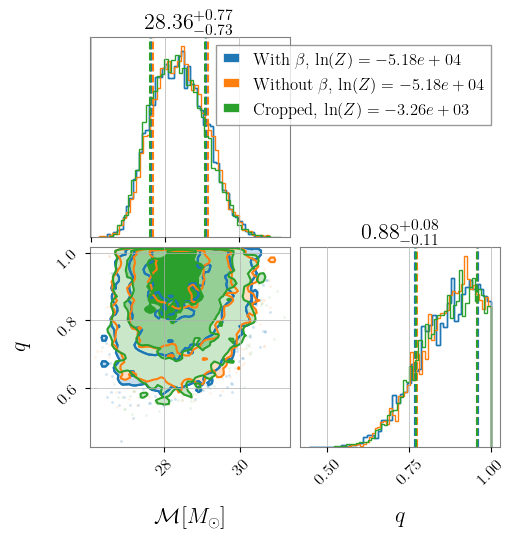

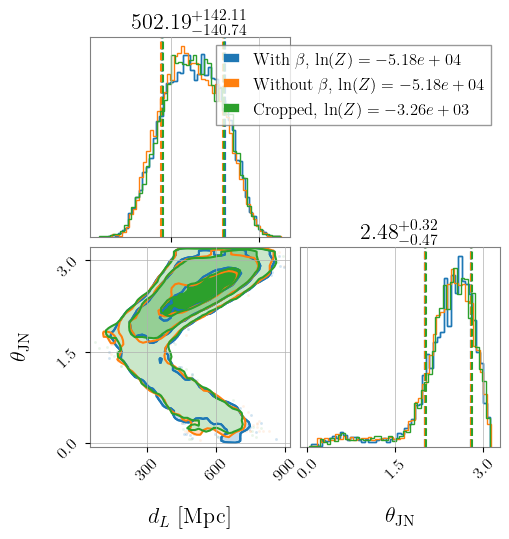

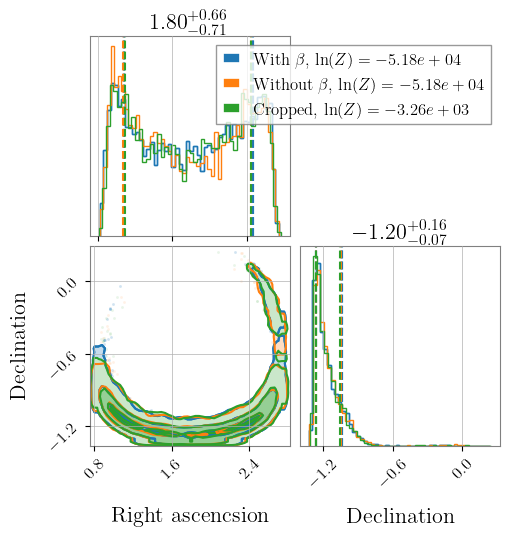

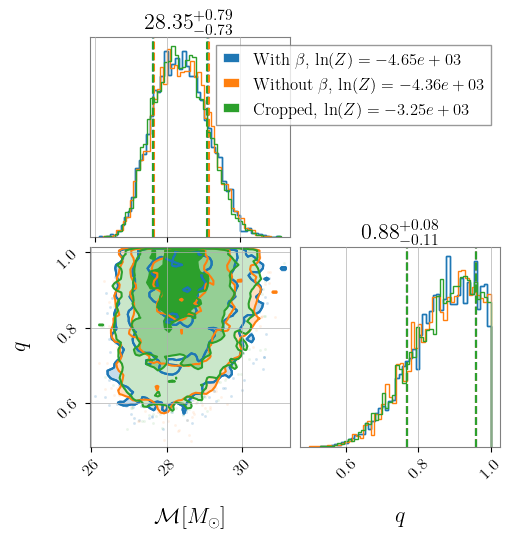

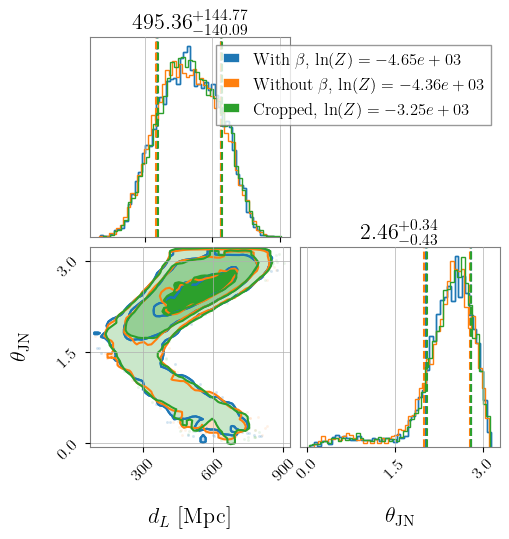

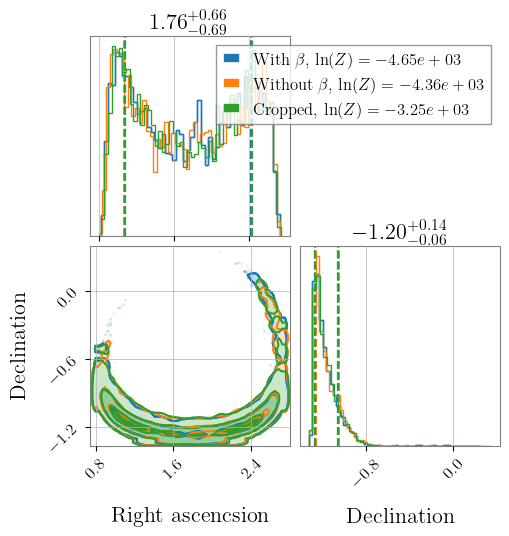

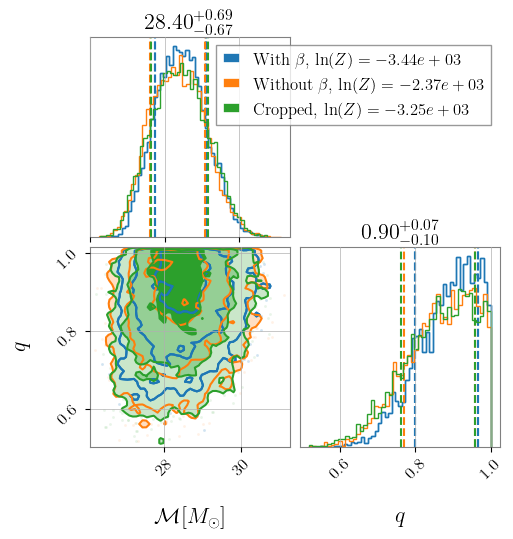

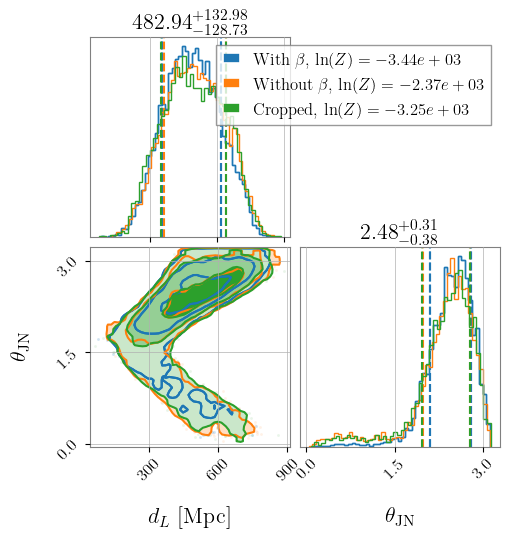

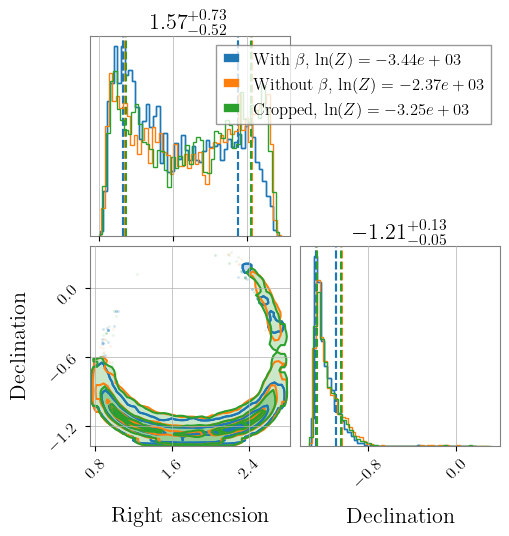

In [ ]:
for roll_off in roll_offs:

    results = [
        bilby.core.result.read_in_result(
            f"{kind}_version/GW150914_window_{roll_off:.1f}_result.json"
            )
        for kind in ["old", "new", "cropped"]
    ]
    for result in results:
        result.log_bayes_factor = np.nan

    labels = ["With $\\beta$,", "Without $\\beta$,", "Cropped,"]

    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["chirp_mass_source", "mass_ratio"],
        corner_labels=["$\\mathcal{M} [M_{\\odot}]$", "$q$"],
        labels=labels,
        filename=f"comparison_mass_{roll_off:.1f}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["luminosity_distance", "theta_jn"],
        corner_labels=["$d_{L}$ [Mpc]", "$\\theta_{\\rm JN}$"],
        labels=labels,
        filename=f"comparison_distance_{roll_off:.1f}.pdf",
        evidences=True,
    )
    _ = bilby.core.result.plot_multiple(
        results,
        parameters=["ra", "dec"],
        corner_labels=["Right ascencsion", "Declination"],
        labels=labels,
        filename=f"comparison_sky_{roll_off:.1f}.pdf",
        evidences=True,
    )
